In [43]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader

from models import hybrid_CNN_BiLSTM
from models.hybrid_CNN_BiLSTM import HybridCNNBiLSTM
from models.simple_biLSTM import BiLSTMClassifier
from src.dataset_factory import DatasetFactory
from src.experiment_runner import ExperimentRunner
from src.nn_trainer import NNTrainer
from src.nn_utils import JournalDataset

In [44]:
def get_pytorch_scores(model_path, model_class, dataset_args, device):
    """Extract probabilities from a PyTorch model."""
    
    model = model_class(**dataset_args['model_params']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    
    loader = DataLoader(dataset_args['dataset'], batch_size=32, shuffle=False)
    
    all_probs = []
    with torch.no_grad():
        for batch in loader:
            ids = batch['ids'].to(device)
            outputs = model(ids)
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
    return np.vstack(all_probs)

def plot_unified_roc(experiments_config, y_test_labels, device='cpu'):
    """
    experiments_config: list of dicts with experiment configurations, e.g.:
    {'name': 'RF', 'path': '...', 'type': 'sklearn'} or
    {'name': 'BiLSTM', 'path': '...', 'type': 'torch', 'class': BiLSTMClassifier, 'params': {...}, 'dataset': ...}
    """
    plt.figure(figsize=(12, 8))
    classes = np.unique(y_test_labels)
    y_test_bin = label_binarize(y_test_labels, classes=classes)
    n_classes = len(classes)

    for exp in experiments_config:
        print(f"Processing {exp['name']}...")
        
        if exp['type'] == 'sklearn':
            pipeline = joblib.load(exp['path'])
            if hasattr(pipeline, "predict_proba"):
                y_score = pipeline.predict_proba(exp['X_test'])
            else:
                y_score = pipeline.decision_function(exp['X_test'])
        
        elif exp['type'] == 'torch':
            y_score = get_pytorch_scores(
                exp['path'], exp['class'], 
                {'model_params': exp['params'], 'dataset': exp['dataset']}, 
                device
            )

        
        all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            mean_tpr += np.interp(all_fpr, fpr, tpr)
        
        mean_tpr /= n_classes
        plt.plot(all_fpr, mean_tpr, label=f"{exp['name']} (AUC = {auc(all_fpr, mean_tpr):.2f})", lw=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('Global Comparative: Classic Models vs Deep Learning')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [45]:

factory = DatasetFactory()
df = factory.create_ml_dataset('master_ml')

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['journal'], test_size=0.15, stratify=df['journal'], random_state=42
)

df_nn = factory.create_dl_dataset('master_nn')

train_df, test_df = train_test_split(df_nn, test_size=0.15, stratify=df_nn['label_idx'], random_state=42)

Generating ML dataset for experiment: master_ml...
Dataset ML guardado en data/experiments/master_ml/dataset_ml.csv
Generating DL dataset for experiment: master_nn...
Dataset DL and mapping saved in data/experiments/master_nn


In [46]:

import json
vocab_file = "data/experiments/BiLSTM_Simple_V11/vocab.json"
with open(vocab_file, 'r') as f:
    vocab = json.load(f)

vocab_file_hybrid = "data/experiments/Hybrid_CNN_BiLSTM_V7/vocab.json"
with open(vocab_file_hybrid, 'r') as f:
    vocab_hybrid = json.load(f)

Processing SVM RBF (ML)...
Processing Hybrid CNN-BiLSTM (DL)...


c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Processing BiLSTM Classifier (DL)...


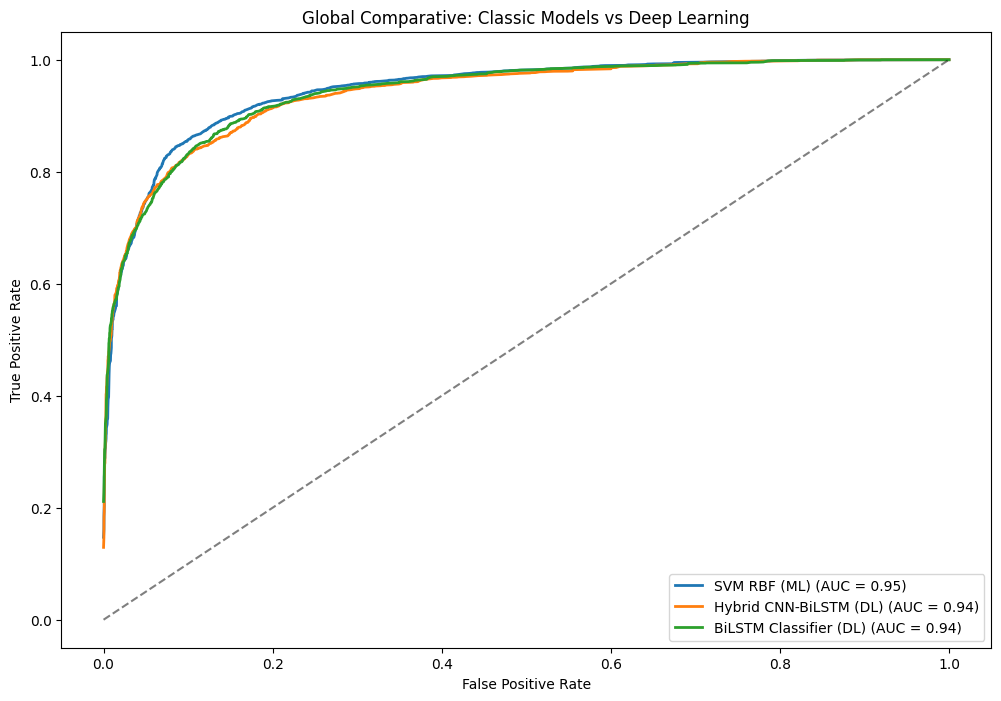

In [ ]:

config_global = [
    #{
    #    'name': 'SVM RBF (ML)',
    #    'type': 'sklearn',
    #    'path': 'results/experiments/SVM_RBF_Smote/SVM_RBF_Smote_model.joblib',
    #    'X_test': X_test 
    #},
    {
        'name': 'Hybrid CNN-BiLSTM (DL)',
        'type': 'torch',
        'path': 'data/experiments/Hybrid_CNN_BiLSTM_V8/best_model.pth',
        'class': HybridCNNBiLSTM,
        'params': {
            'vocab_size': len(vocab_hybrid), 'embed_dim': 128, 'n_filters': 100, 
            'filter_sizes': [3, 4, 5], 'hidden_dim': 32, 'output_dim': df_nn['label_idx'].nunique()
        },
        'dataset': JournalDataset(test_df['processed_text'], test_df['label_idx'], vocab_hybrid)
    },
    {
        'name': 'BiLSTM Classifier (DL)',
        'type': 'torch',
        'path': 'data/experiments/BiLSTM_Simple_V12/best_model.pth',
        'class': BiLSTMClassifier,
        'params': {
            'vocab_size': len(vocab), 'embed_dim': 128,
            'hidden_dim': 32, 'output_dim': df_nn['label_idx'].nunique()
        },
        'dataset': JournalDataset(test_df['processed_text'], test_df['label_idx'], vocab)
    }
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plot_unified_roc(config_global, test_df['label_idx'].values, device=device)

Processing SVM RBF (ML)...
Processing Random Forest (ML)...
Processing Logistic Regression (ML)...
Processing SVM Linear (ML)...
Processing Naive Bayes (ML)...


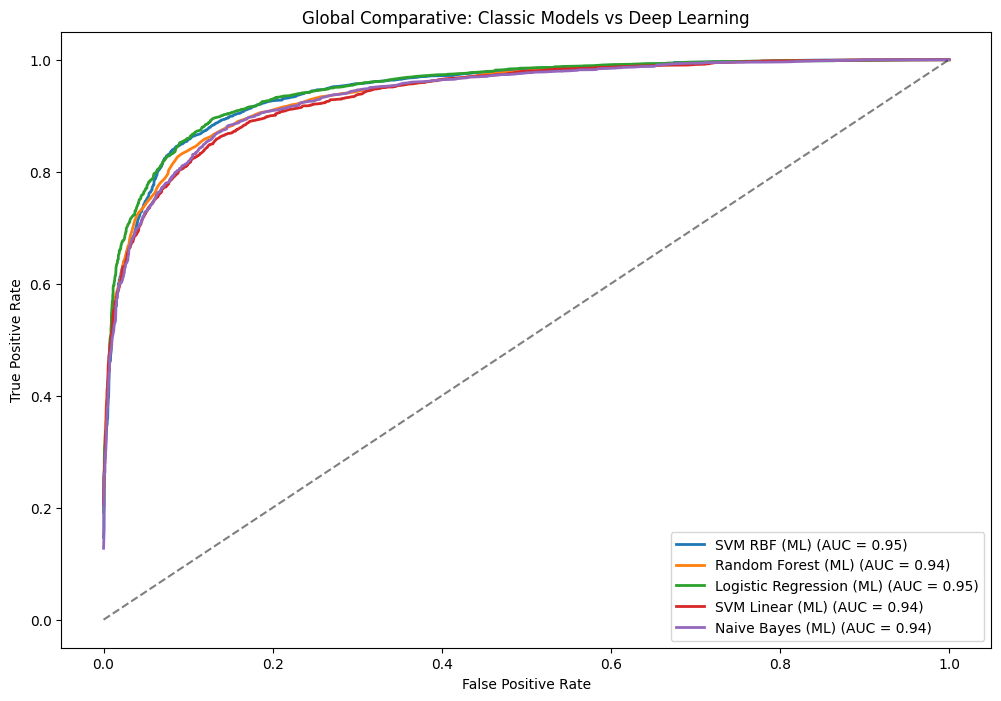

In [48]:

ML_experiments = [{
        'name': 'SVM RBF (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/SVM_RBF_Smote/SVM_RBF_Smote_model.joblib',
        'X_test': X_test 
    },
    {
        'name': 'Random Forest (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/Rf_tFIDF_Smote/RF_Tfidf_Smote_model.joblib',
        'X_test': X_test
    },
    {
        'name': 'Logistic Regression (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/Logistic_Regression_Tfidf/Logistic_Regression_Tfidf_model.joblib',
        'X_test': X_test
    },
    {
        'name': 'SVM Linear (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/SVM_Linear_Smote/SVM_Linear_Smote_model.joblib',
        'X_test': X_test
    },
    {
        'name': 'Naive Bayes (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/Naive_Bayes_Tfidf/Naive_Bayes_Tfidf_model.joblib',
        'X_test': X_test
    }
    ]

plot_unified_roc(ML_experiments, y_test.values, device=device)

In [49]:
#matriz de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#plot confusion matrix for the best model
best_model_config = {
        'name': 'SVM RBF (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/SVM_RBF_Smote/SVM_RBF_Smote_model.joblib',
        'X_test': X_test 
    }
best_pipeline = joblib.load(best_model_config['path'])
y_pred = best_pipeline.predict(best_model_config['X_test'])




In [50]:
base_path = 'results_comparative/'
os.makedirs(base_path, exist_ok=True)
experiment_runner = ExperimentRunner(base_path = base_path)
experiment_runner._save_confusion_matrix(y_true = y_test, y_pred = y_pred, path = base_path)

In [51]:
def save_confusion_matrix(y_true, y_pred, path):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de Confusión')
        plt.ylabel('Realidad')
        plt.xlabel('Predicción')
        plt.savefig(os.path.join(path, 'confusion_matrix.png'))
        plt.close()


In [52]:
#display confusion matrix for the hybrid model
y_test_labels = test_df['label_idx'].values
y_score_hybrid = get_pytorch_scores(
    'data/experiments/Hybrid_CNN_BiLSTM_V8/best_model.pth', HybridCNNBiLSTM, 
    {'model_params': {
        'vocab_size': len(vocab_hybrid), 'embed_dim': 128, 'n_filters': 100, 
        'filter_sizes': [3, 4, 5], 'hidden_dim': 32, 'output_dim': df_nn['label_idx'].nunique()
    }, 'dataset': JournalDataset(test_df['processed_text'], test_df['label_idx'], vocab_hybrid)}, 
    device
)
y_pred_hybrid = np.argmax(y_score_hybrid, axis=1)

save_confusion_matrix(y_pred=y_pred_hybrid, y_true=y_test_labels, path=base_path)

c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [53]:
#display confusion matrix for the biLSTM model
y_score_bilstm = get_pytorch_scores(
    'data/experiments/BiLSTM_Simple_V12/best_model.pth', BiLSTMClassifier, 
    {'model_params': {
        'vocab_size': len(vocab), 'embed_dim': 128,
        'hidden_dim': 32, 'output_dim': df_nn['label_idx'].nunique()
    }, 'dataset': JournalDataset(test_df['processed_text'], test_df['label_idx'], vocab)}, 
    device
)
y_pred_bilstm = np.argmax(y_score_bilstm, axis=1)

save_confusion_matrix(y_pred=y_pred_bilstm, y_true=y_test_labels, path=base_path)
